In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost
import graphviz

RANDOM_SEED = 1212

## Data Loading

In [3]:
train = pd.read_csv('../data/small/train/orange_small_train.data', sep="\t")
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [4]:
churn_label = (
    pd.read_csv(
        "../data/small/labels/orange_small_train_churn.labels", sep="\t", header=None
    )
    .iloc[:, 0]
    .astype("category")
)

churn_label.cat.rename_categories([0, 1], inplace=True)

churn_label.head()

0    0
1    1
2    0
3    0
4    0
Name: 0, dtype: category
Categories (2, int64): [0, 1]

## Dataframe Conversion

In [5]:
def convert_dataframe(DF):
    df_var_names = DF.columns

    df_types = {df_var_name: DF[df_var_name].dtype for df_var_name in df_var_names}

    for df_var_name in df_var_names:
        if df_types[df_var_name] == int:
            df = DF[df_var_name].astype(float)
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

        elif df_types[df_var_name] != float:
            df = DF[df_var_name].astype("category")
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

    return DF, df_types

In [6]:
train, train_types = convert_dataframe(train)

## Data Cleaning and Filling

In [7]:
def plot_missing_data(train):
    train_missing = train.isnull().sum() / train.shape[0]

    plt.figure(figsize=(15,5))
    
    plt.hist(train_missing, bins=50)

    plt.title("Missing data proportions on Train set")
    plt.show()

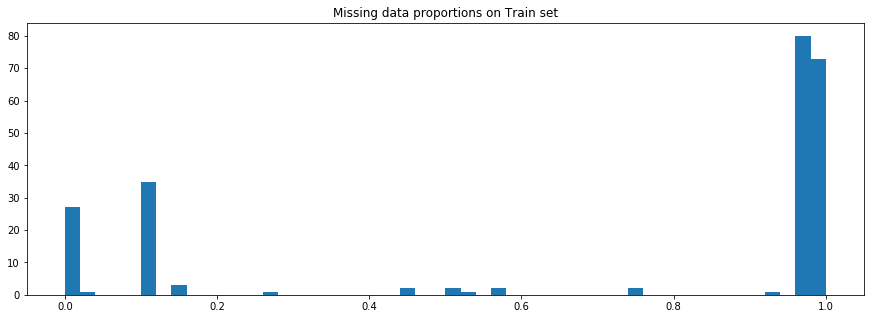

In [8]:
plot_missing_data(train)

I'll consider valid only features that have less than 15% missing data of its total data as our model features

In [9]:
train_missing = train.isnull().sum() / train.shape[0]
features = train_missing[train_missing <= 0.15].index

print(features)
print(len(features))

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76',
       'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113',
       'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173',
       'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227',
       'Var228'],
      dtype='object')
66


Filling the missing numeric values with respective column mean values

In [10]:
numeric_features = [feat for feat in features if train_types[feat] == float]

print(numeric_features)
print(len(numeric_features))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181']
38


In [11]:
train[numeric_features] = train[numeric_features].fillna(
    train[numeric_features].mean()
)

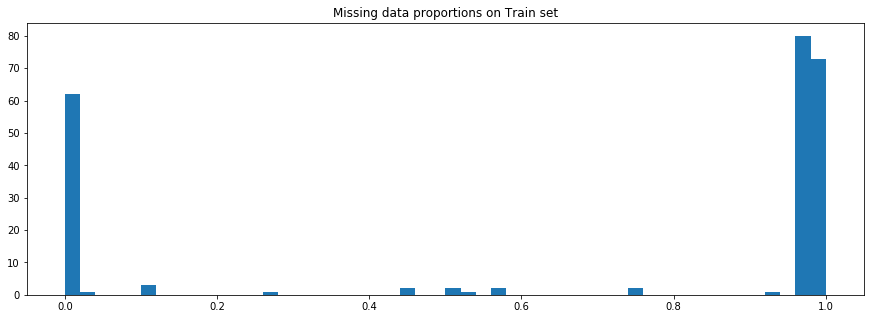

In [12]:
plot_missing_data(train)

I'll now remove the categorical features that have more than 400 categories in it

In [13]:
categorical_features = [feat for feat in features if train_types[feat] != float]

print(categorical_features)
print(len(categorical_features))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227', 'Var228']
28


In [14]:
categorical_levels = train[categorical_features].apply(lambda col: len(col.cat.categories))

categorical_features_filtered = categorical_levels[categorical_levels <= 400].index.tolist()
print(categorical_features_filtered)
print(len(categorical_features_filtered))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
21


In [15]:
features_filtered = numeric_features + categorical_features_filtered
print(features_filtered)
print(len(features_filtered))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
59


Feature Selection

In [16]:
train = train[features_filtered]

Getting dummy variables for category columns

In [17]:
train = pd.get_dummies(train, dtype=bool)

Scaling between $[0,1]$ numeric features

In [18]:
scaler = MinMaxScaler()
train[numeric_features] = scaler.fit_transform(train[numeric_features])

In [19]:
train[numeric_features].describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.010067,0.048639,0.006316,0.006466,0.006402,0.009125,0.007353,0.055763,0.006516,0.136845,...,0.076254,0.002653,0.003223,0.144786,0.017415,0.444496,0.007981,0.033488,0.001141,0.012479
std,0.019223,0.042610,0.013320,0.014705,0.014739,0.018589,0.015439,0.017884,0.025836,0.151501,...,0.099954,0.007229,0.033889,0.136460,0.035876,0.296620,0.019412,0.055474,0.020948,0.048314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004409,0.000000,0.000020,0.003308,0.003308,0.000000,0.001215,0.044674,0.000000,0.000935,...,0.007234,0.000000,0.000000,0.000000,0.000000,0.115654,0.002057,0.000000,0.000000,0.000000
50%,0.007172,0.050000,0.001900,0.004301,0.004191,0.004049,0.004253,0.054916,0.000000,0.110024,...,0.049449,0.000692,0.000000,0.111111,0.007292,0.444496,0.005348,0.014470,0.000000,0.000000
75%,0.010067,0.050000,0.006388,0.006466,0.006402,0.009125,0.007898,0.061974,0.000000,0.225029,...,0.095744,0.002653,0.000000,0.222222,0.018113,0.742959,0.007981,0.036197,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train, Validation and Test split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    train, churn_label, test_size=0.2, random_state=RANDOM_SEED
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=RANDOM_SEED
)

In [21]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(32000, 1031)
(8000, 1031)
(10000, 1031)


## Model Training

### XGBoost Classifier

In [22]:
xgb = xgboost.XGBClassifier(
    n_jobs=8,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=2000,
    random_state=RANDOM_SEED,
)

In [23]:
xgb.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=True,
)

[0]	validation_0-auc:0.592133
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.592307
[2]	validation_0-auc:0.593291
[3]	validation_0-auc:0.592059
[4]	validation_0-auc:0.590834
[5]	validation_0-auc:0.590382
[6]	validation_0-auc:0.590445
[7]	validation_0-auc:0.59085
[8]	validation_0-auc:0.595243
[9]	validation_0-auc:0.592868
[10]	validation_0-auc:0.592713
[11]	validation_0-auc:0.592841
[12]	validation_0-auc:0.593998
[13]	validation_0-auc:0.594239
[14]	validation_0-auc:0.593643
[15]	validation_0-auc:0.594021
[16]	validation_0-auc:0.595786
[17]	validation_0-auc:0.596016
[18]	validation_0-auc:0.596069
[19]	validation_0-auc:0.597474
[20]	validation_0-auc:0.597336
[21]	validation_0-auc:0.597389
[22]	validation_0-auc:0.598089
[23]	validation_0-auc:0.597368
[24]	validation_0-auc:0.597843
[25]	validation_0-auc:0.597876
[26]	validation_0-auc:0.597843
[27]	validation_0-auc:0.597392
[28]	validation_0-auc:0.597894
[29]	validation_0-auc:0.598183
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
              n_jobs=8, nthread=None, objective='binary:logistic',
              random_state=1212, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [24]:
y_score_xgb = xgb.predict_proba(x_test)

### GradientBoostingClassifier

In [25]:
gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=10,
    warm_start=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    random_state=RANDOM_SEED,
    verbose=1,
)

In [26]:
gbc.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5009           25.20m
         2           0.4824           23.25m
         3           0.4700           22.54m
         4           0.4588           22.60m
         5           0.4474           22.79m
         6           0.4384           21.94m
         7           0.4288           21.48m
         8           0.4218           21.01m
         9           0.4136           20.94m
        10           0.4084           20.69m
        20           0.3489           21.35m


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=20, presort='auto',
                           random_state=1212, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=1, warm_start=True)

In [27]:
y_score_gdb = gbc.predict_proba(x_test)

### RandomForestClassifier

In [28]:
rfc = RandomForestClassifier(
    n_estimators=2000, max_depth=10, n_jobs=8, random_state=RANDOM_SEED, verbose=1
)

In [29]:
rfc.fit(x_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   32.2s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   36.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=8, oob_score=False, random_state=1212, verbose=1,
                       warm_start=False)

In [30]:
y_score_rfc = rfc.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    1.2s finished


### Support Vector Machine Classifier

In [31]:
svc = SVC(
    gamma="auto",
    kernel="rbf",
    max_iter=1e+4,
    probability=True,
    random_state=RANDOM_SEED,
    verbose=1,
)

In [32]:
svc.fit(x_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=10000.0, probability=True, random_state=1212, shrinking=True,
    tol=0.001, verbose=1)

In [33]:
y_score_svc = svc.predict_proba(x_test)

### Linear Support Vector Machine Classifier

In [34]:
lsvc = SVC(
    gamma="auto",
    kernel="linear",
    max_iter=1e+4,
    probability=True,
    random_state=RANDOM_SEED,
    verbose=1,
)

In [35]:
lsvc.fit(x_train, y_train)

[LibSVM]

/home/ronald/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=10000.0, probability=True, random_state=1212, shrinking=True,
    tol=0.001, verbose=1)

In [36]:
y_score_lsvc = lsvc.predict_proba(x_test)

### Multi-Layer Perceptron Neural Network Classifier

In [37]:
mlp = MLPClassifier(
    hidden_layer_sizes=(2 ** 10, 2 ** 8, 2 ** 6, 2 ** 4),
    activation="relu",
    max_iter=int(1e+3),
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=50,
    random_state=RANDOM_SEED,
    verbose=True,
)

In [38]:
mlp.fit(x_train, y_train)

Iteration 1, loss = 0.27371108
Validation score: 0.926094
Iteration 2, loss = 0.24976104
Validation score: 0.926094
Iteration 3, loss = 0.24006685
Validation score: 0.926094
Iteration 4, loss = 0.22390293
Validation score: 0.925000
Iteration 5, loss = 0.18827552
Validation score: 0.921094
Iteration 6, loss = 0.14008160
Validation score: 0.912188
Iteration 7, loss = 0.10170958
Validation score: 0.902656
Iteration 8, loss = 0.07492045
Validation score: 0.906875
Iteration 9, loss = 0.05464027
Validation score: 0.906875
Iteration 10, loss = 0.04332867
Validation score: 0.903438
Iteration 11, loss = 0.03434972
Validation score: 0.896875
Iteration 12, loss = 0.02726287
Validation score: 0.902656
Iteration 13, loss = 0.02467004
Validation score: 0.907344
Iteration 14, loss = 0.02152469
Validation score: 0.888906
Iteration 15, loss = 0.02009252
Validation score: 0.910781
Iteration 16, loss = 0.01636311
Validation score: 0.899687
Iteration 17, loss = 0.01523580
Validation score: 0.892813
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(1024, 256, 64, 16), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
              random_state=1212, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.2, verbose=True, warm_start=False)

In [39]:
y_score_mlp = mlp.predict_proba(x_test)

## AUC Comparison

In [40]:
def plot_roc_curve(y_true, y_score, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve for Churn class (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for %s model" % model_name)
    plt.legend(loc="lower right")
    plt.show()

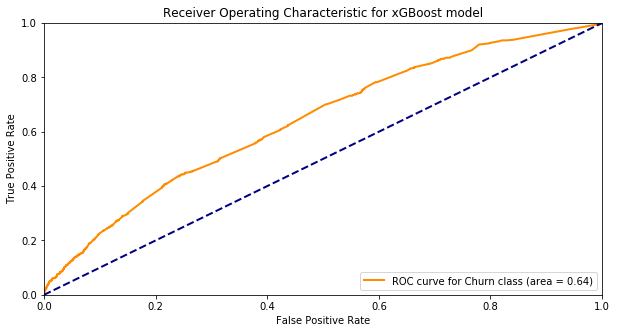

In [41]:
plot_roc_curve(y_test, y_score_xgb, "xGBoost")

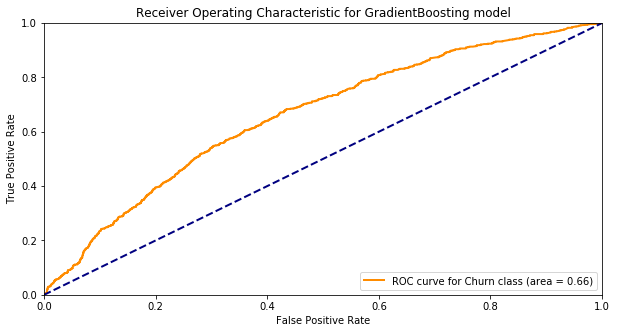

In [42]:
plot_roc_curve(y_test, y_score_gdb, "GradientBoosting")

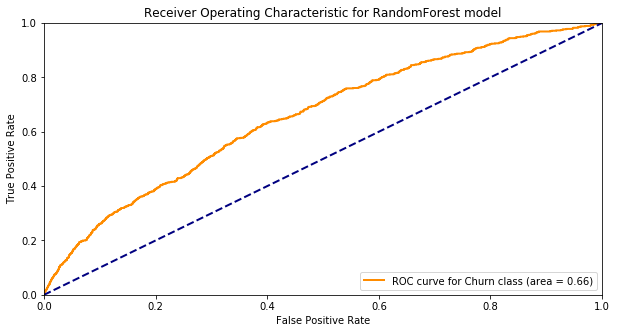

In [43]:
plot_roc_curve(y_test, y_score_rfc, "RandomForest")

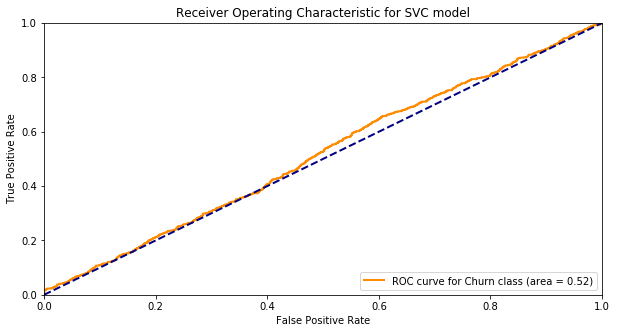

In [44]:
plot_roc_curve(y_test, y_score_svc, "SVC")

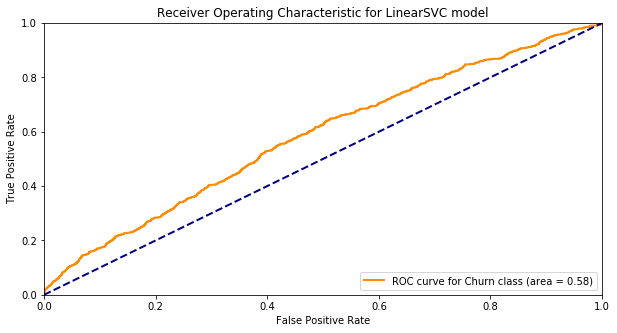

In [45]:
plot_roc_curve(y_test, y_score_lsvc, "LinearSVC")

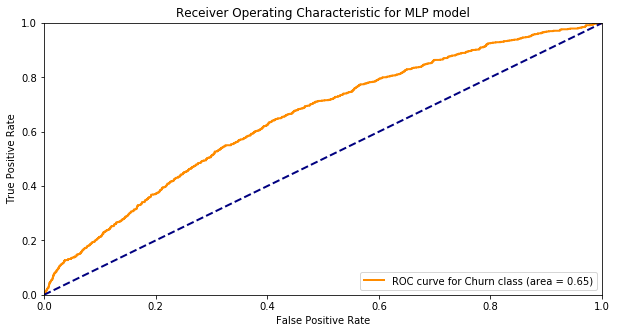

In [46]:
plot_roc_curve(y_test, y_score_mlp, "MLP")